In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [23]:
first_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print(first_date)

2016-08-23


In [24]:
prcp_data = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

prcp_df = pd.DataFrame(prcp_data, columns=['date','prcp'])
prcp_df.set_index('date').head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


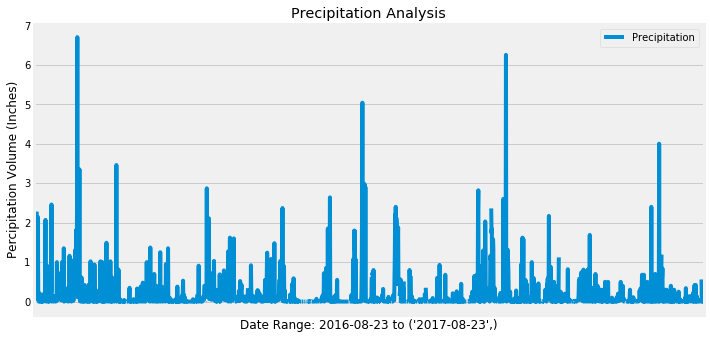

In [85]:
prcp_df.plot('date', 'prcp', label = "Precipitation", figsize = (10,5))
plt.xlabel(f"Date Range: {first_date} to {last_date}")
plt.ylabel("Percipitation Volume (Inches)")
plt.title("Precipitation Analysis")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks([])
plt.savefig('Images/precipitation.png')

plt.show()

In [53]:
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [58]:
stations_available = session.query(Measurement).group_by(Measurement.station).count()
print(f'There are {stations_available} available in this dataset. ')

There are 9 available in this dataset. 


In [62]:
popular_stations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

for station, count in popular_stations:
    print(station, count)


USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [76]:
temperatures = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == popular_station).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()


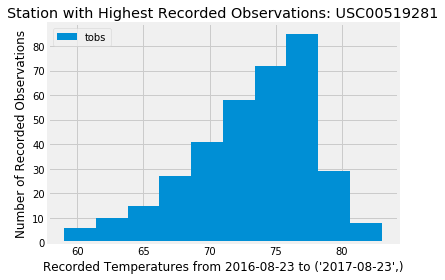

In [96]:
plt.grid(True)
temp_df = pd.DataFrame(temperatures)
plt.hist(temp_df['tobs'], label="tobs")
bin_size = 12
plt.xlabel(f"Recorded Temperatures from {first_date} to {last_date}")
plt.ylabel("Number of Recorded Observations")
plt.title(f"Station with Highest Recorded Observations: {popular_station}")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig('Images/temperatures.png')

plt.show()

In [97]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [98]:
prev_year_start = dt.date(2018,1,1) - dt.timedelta(days= 365)
prev_year_end = prev_year_start + dt.timedelta(days = 5)
calc_temp = calc_temps(prev_year_start,prev_year_end)
print(calc_temp)

[(62.0, 68.05714285714286, 74.0)]


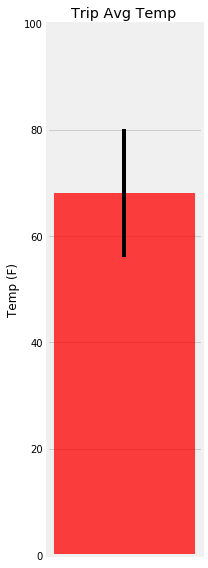

In [107]:
ta_temp= list(np.ravel(calc_temp))
#ta_temp
tmin = ta_temp[0]
tmax = ta_temp[2]
temp_avg = ta_temp[1]
plt.figure(figsize=(3,8))
plt.bar(1,temp_avg, color = 'red',alpha = 0.75)
plt.errorbar(1,temp_avg, yerr=(tmax - tmin), color = 'k')
plt.ylim(0, 100)
plt.xticks([])
plt.title('Trip Avg Temp')
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.savefig('Images/avg_temp.png')

plt.show()

In [108]:
rainfall_per_station = session.query(Station.station, Station.name, Station.latitude,
                                 Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
        filter(Measurement.date >= prev_year_start, Measurement.date <= prev_year_end).\
        filter(Measurement.prcp != None).\
        filter(Station.station == Measurement.station).\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()
print(rainfall_per_station)

[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.61), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.6), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.6), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.29), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.2), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]
